In [2]:
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
from cmocean import cm
from matplotlib import colors
from matplotlib import axes

import warnings
#warnings.simplefilter('ignore')
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

In [10]:
glob?

Signature: glob(pathname, *, recursive=False)
Docstring:
Return a list of paths matching a pathname pattern.

The pattern may contain simple shell-style wildcards a la
fnmatch. However, unlike fnmatch, filenames starting with a
dot are special cases that are not matched by '*' and '?'
patterns.

If recursive is true, the pattern '**' will match any files and
zero or more directories and subdirectories.
File:      ~/miniconda3/envs/py3_std/lib/python3.7/glob.py
Type:      function


### Define path to data - ORCA025

In [2]:
maskdir = '/scratch/usr/shklvn09/NUDATA/ORCA/025-data/meshmask/mesh_mask.nc'
mask = xr.open_dataset(maskdir,
                      chunks={"z":46, "y":100, "x":100}).tmask.squeeze() #allocating variable in chunks reduces the memory usage

In [ ]:
mask

In [3]:
mask = mask.rename({'z':'deptht'})

In [4]:
path_ryf = '/scratch/usr/shkifmmp/ORCA025/RYF/yearly/mops/'
path_hind = '/scratch/usr/shkifmmp/ORCA025/hindcast/yearly/mops/'

out_ryf = sorted(glob(path_ryf + '*1y*_potdensity.nc'))
out_hind = sorted(glob(path_hind + '*1y*_potdensity.nc'))

In [5]:
!ncdump -h /scratch/usr/shkifmmp/ORCA025/RYF/yearly/mops/ORCA025.L46.LIM2vp.CFCSF6.MOPS.JRA.L.LP03-KLP004_1y_19580101_19581231_potdensity.nc

netcdf ORCA025.L46.LIM2vp.CFCSF6.MOPS.JRA.L.LP03-KLP004_1y_19580101_19581231_potdensity {
dimensions:
	x = 1442 ;
	y = 1021 ;
	deptht = 46 ;
	time_counter = UNLIMITED ; // (1 currently)
variables:
	float nav_lon(y, x) ;
		nav_lon:standard_name = "longitude" ;
		nav_lon:long_name = "Longitude" ;
		nav_lon:units = "degrees_east" ;
	float nav_lat(y, x) ;
		nav_lat:standard_name = "latitude" ;
		nav_lat:long_name = "Latitude" ;
		nav_lat:units = "degrees_north" ;
	float deptht(deptht) ;
		deptht:name = "deptht" ;
		deptht:long_name = "Vertical T levels" ;
		deptht:units = "m" ;
		deptht:positive = "down" ;
		deptht:bounds = "deptht_bounds" ;
	double time_counter(time_counter) ;
		time_counter:axis = "T" ;
		time_counter:standard_name = "time" ;
		time_counter:long_name = "Time axis" ;
		time_counter:calendar = "gregorian" ;
		time_counter:units = "seconds since 1900-01-01 00:00:00" ;
		time_counter:time_origin = "1900-01-01 00:00:00" ;
		time_counter:bounds = "time_counter_bounds" ;
		time

In [6]:
rho_ryf = xr.open_mfdataset(out_ryf,
                           chunks={"time_counter":1, "deptht":46, "y":100, "x":100}).vosigmai
#rho_hind = xr.open_mfdataset(out_hind,
#                             chunks={"time_counter":1, "deptht":46, "y":100, "x":100}).vosigmai

In [ ]:
rho_ryf

#### Getting longitudes

In [15]:
#lon = rho_ryf.nav_lon.isel(y = 500, time_counter=0)

In [16]:
#np.where(lon == -25) # ATLANTIC

(array([1049]),)

In [17]:
#np.where(lon == -144) # PACIFIC

(array([573]),)

In [18]:
#np.where(lon == 70) # INDIAN

(array([1429]),)

#### grid for plotting

In [7]:
lat = xr.open_mfdataset(out_ryf,
                           chunks={"time_counter":1, "deptht":46, "y":100, "x":100}).nav_lat.isel(time_counter=0, x=1049)

In [8]:
depth = xr.open_mfdataset(out_ryf,
                           chunks={"time_counter":1, "deptht":46, "y":100, "x":100}).deptht

In [71]:
np.where(depth <= 5000)
depth[41].values

array(4877.303, dtype=float32)

In [82]:
a= np.where(lat >75)
a[0][0]

895

#### Time-mean (1958-2018) and multiplying by mask

RYF

In [9]:
rho_atl_ryf = rho_ryf.mean(dim='time_counter').where(mask).isel(x=1049) #Atlantic

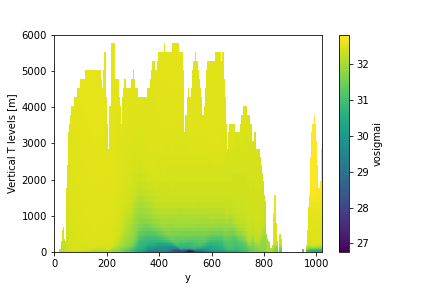

In [10]:
rho_atl_ryf.plot()

In [10]:
rho_pac_ryf = rho_ryf.mean(dim='time_counter').where(mask).isel(x=573) #Pacific

In [11]:
rho_ind_ryf = rho_ryf.mean(dim='time_counter').where(mask).isel(x=1429)  #Indian

HIND

In [8]:
rho_atl_h = rho_hind.mean(dim='time_counter').where(mask).isel(x=1049)  #Atlantic

In [9]:
rho_pac_h = rho_hind.mean(dim='time_counter').where(mask).isel(x=573)  #Pacific

In [10]:
rho_ind_h = rho_hind.mean(dim='time_counter').where(mask).isel(x=1429) #Indic

### Plotting

RYF

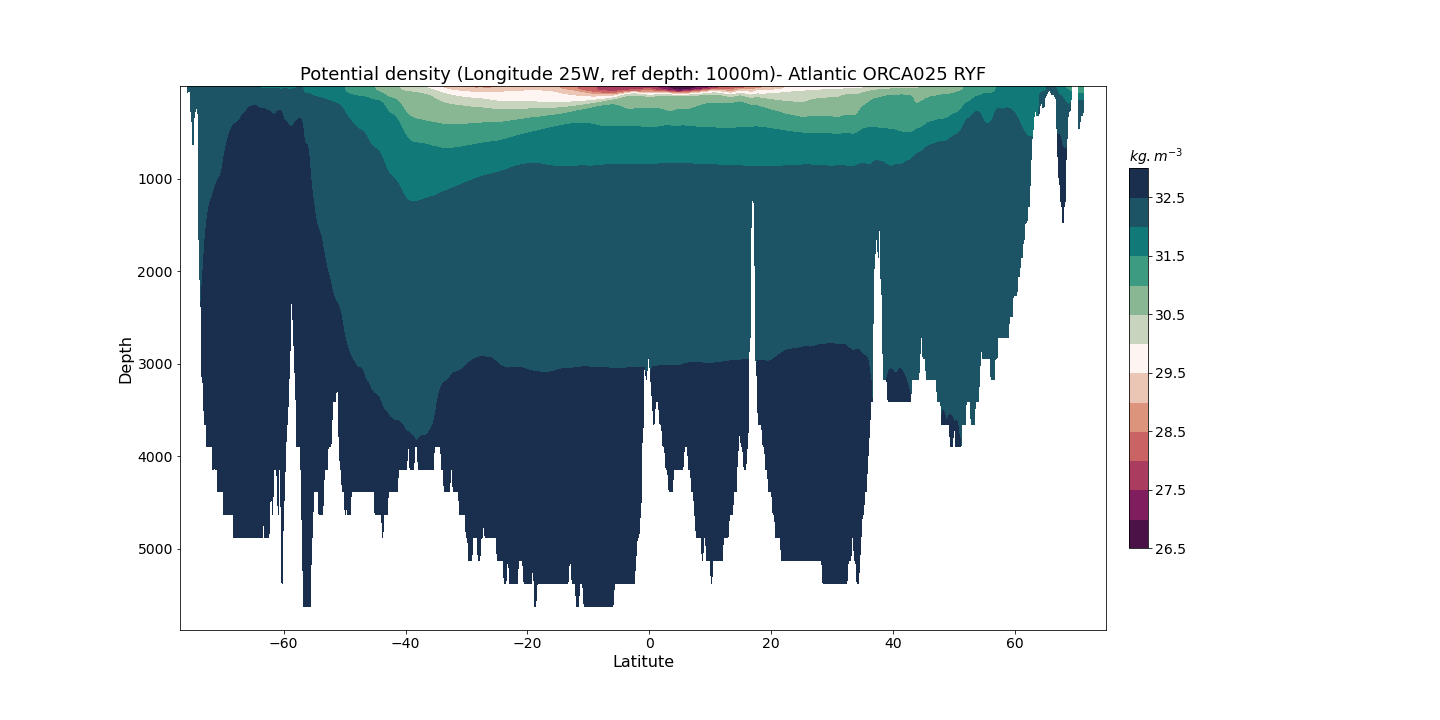

In [12]:
#Atlantic

plt.figure(figsize=(20,10))
ax = plt.gca()

map1 = plt.contourf(lat[:895], depth, rho_atl_ryf.isel(y=slice(0,895)), levels=12,
                      cmap= cm.curl_r ,norm= colors.Normalize())

axes.Axes.tick_params(ax, axis='both' ,labelsize=14)
plt.title('Potential density (Longitude 25W, ref depth: 1000m)- Atlantic ORCA025 RYF', fontsize=18)
plt.xlabel('Latitute', fontsize=16)
plt.ylabel('Depth', fontsize=16)
c= plt.colorbar(map1, pad=0.02, shrink=0.7, ax=ax)
c.ax.set_title('$kg.m^{-3}$', loc='left', fontsize=14)
c.ax.tick_params(labelsize=14)
ax.invert_yaxis()

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/'
plt.savefig(savepath + 'density_atl_ryf.png', format='png', facecolor="w")

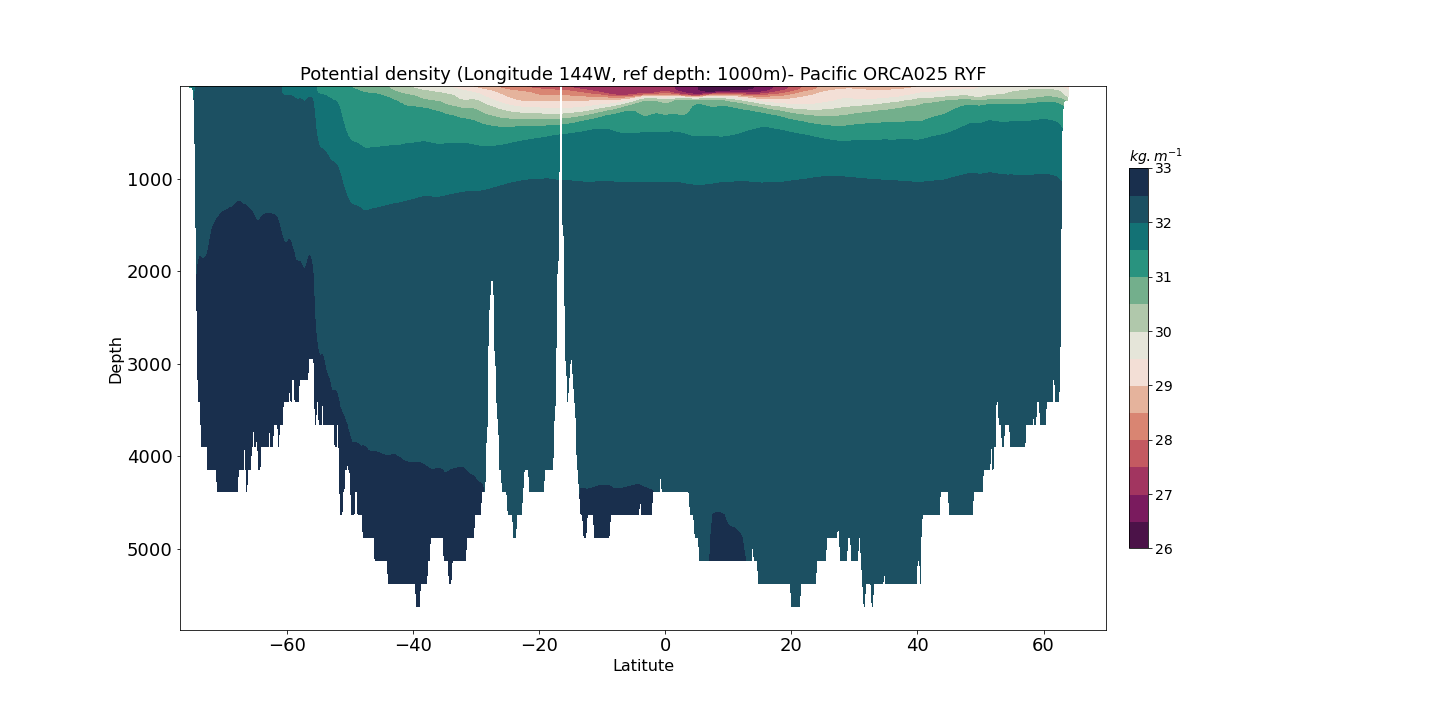

In [13]:
#Pacific

plt.figure(figsize=(20,10))
ax = plt.gca()

map2 = plt.contourf(lat[:858], depth, rho_pac_ryf.isel(y=slice(0,858)), levels=12,
                     cmap = cm.curl_r, norm= colors.Normalize())

axes.Axes.tick_params(ax, axis='both' ,labelsize=18)
plt.title('Potential density (Longitude 144W, ref depth: 1000m)- Pacific ORCA025 RYF', fontsize=18)
plt.xlabel('Latitute', fontsize=16)
plt.ylabel('Depth', fontsize=16)
c= plt.colorbar(map2, pad=0.02, shrink=0.7, ax=ax)
c.ax.set_title('$kg.m^{-1}$', loc='left', fontsize=14)
c.ax.tick_params(labelsize=14)
ax.invert_yaxis()

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/'
plt.savefig(savepath + 'density_pac_ryf.png', format='png', facecolor="w")

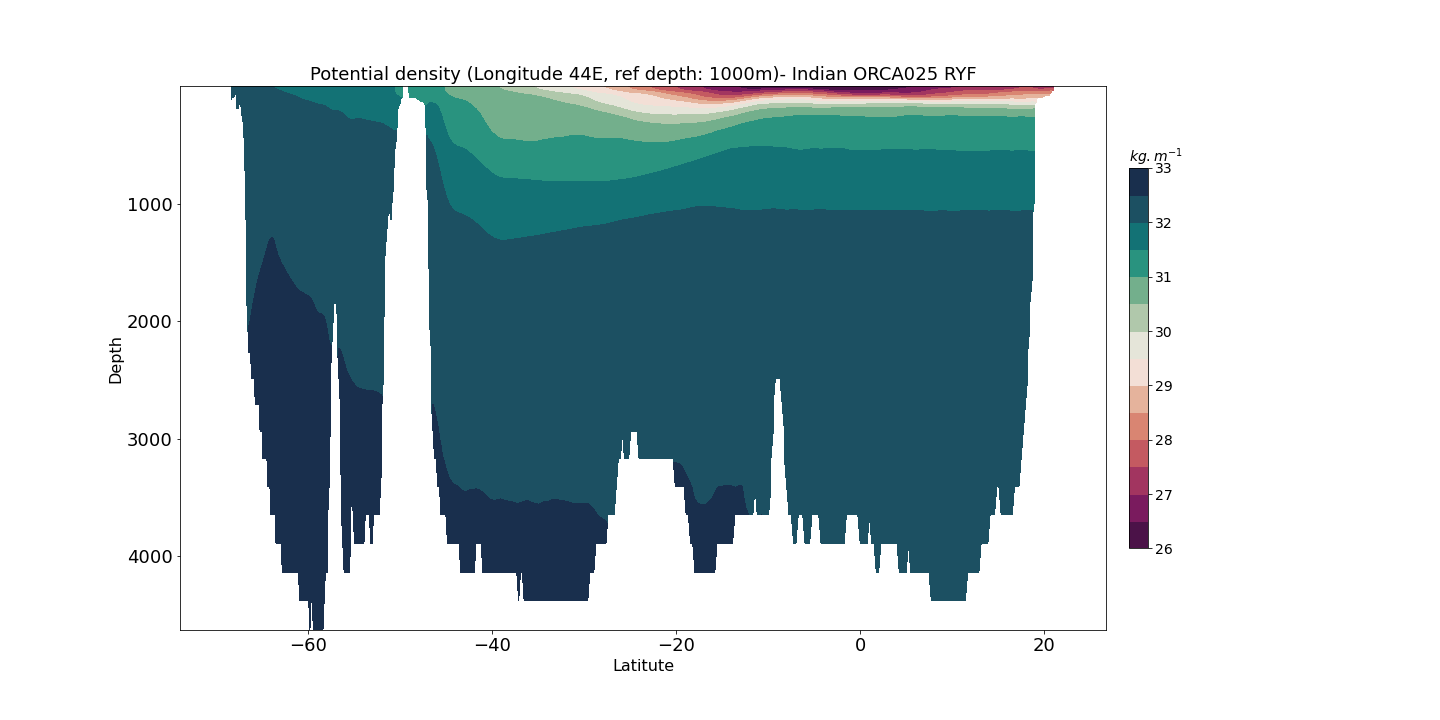

In [14]:
#Indian

plt.figure(figsize=(20,10))
ax = plt.gca()

map3 = plt.contourf(lat[50:610], depth[:41], rho_ind_ryf.isel(y=slice(50,610), deptht=slice(0,41)), levels=12,
                     cmap = cm.curl_r, norm= colors.Normalize())

axes.Axes.tick_params(ax, axis='both' ,labelsize=18)
plt.title('Potential density (Longitude 44E, ref depth: 1000m)- Indian ORCA025 RYF', fontsize=18)
plt.xlabel('Latitute', fontsize=16)
plt.ylabel('Depth', fontsize=16)
c= plt.colorbar(map3, pad=0.02, shrink=0.7, ax=ax)
c.ax.set_title('$kg.m^{-1}$', loc='left', fontsize=14)
c.ax.tick_params(labelsize=14)
ax.invert_yaxis()

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/'
plt.savefig(savepath + 'density_ind_ryf.png', format='png', facecolor="w")

HIND

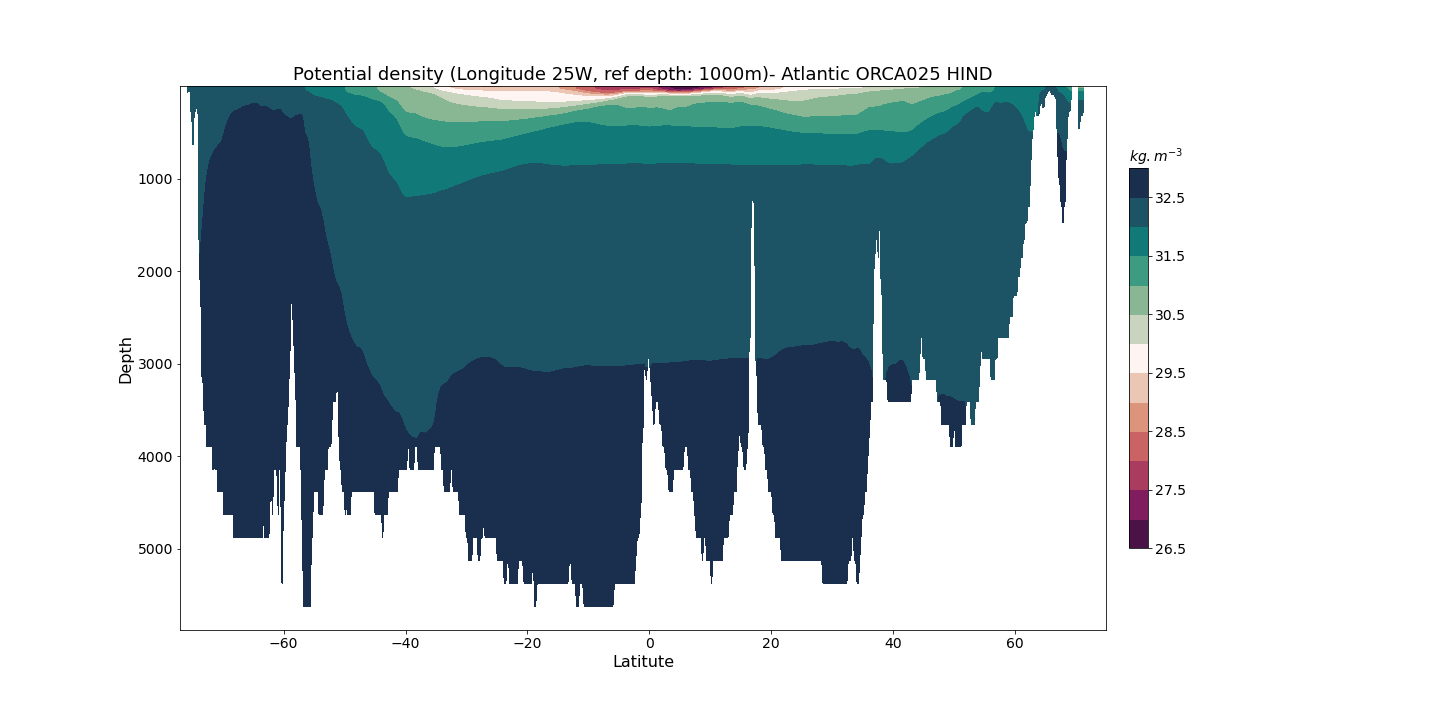

In [11]:
#Atlantic

plt.figure(figsize=(20,10))
ax = plt.gca()

map1 = plt.contourf(lat[:895], depth, rho_atl_h.isel(y=slice(0,895)), levels=12,
                      cmap= cm.curl_r ,norm= colors.Normalize())

axes.Axes.tick_params(ax, axis='both' ,labelsize=14)
plt.title('Potential density (Longitude 25W, ref depth: 1000m)- Atlantic ORCA025 HIND', fontsize=18)
plt.xlabel('Latitute', fontsize=16)
plt.ylabel('Depth', fontsize=16)
c= plt.colorbar(map1, pad=0.02, shrink=0.7, ax=ax)
c.ax.set_title('$kg.m^{-3}$', loc='left', fontsize=14)
c.ax.tick_params(labelsize=14)
ax.invert_yaxis()

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/'
plt.savefig(savepath + 'density_atl_hind.png', format='png', facecolor="w")

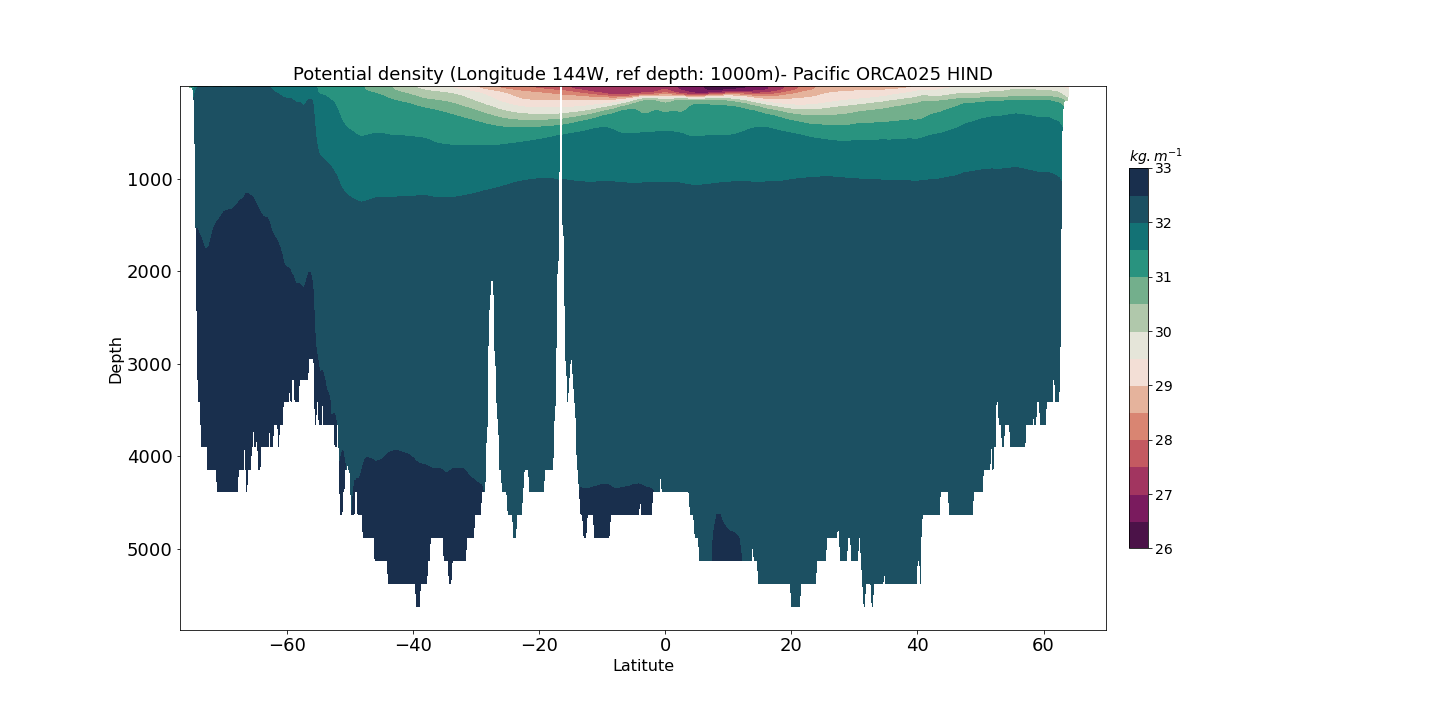

In [12]:
# Pacific
plt.figure(figsize=(20,10))
ax = plt.gca()

map2 = plt.contourf(lat[:858], depth, rho_pac_h.isel(y=slice(0,858)), levels=12,
                     cmap = cm.curl_r, norm= colors.Normalize())

axes.Axes.tick_params(ax, axis='both' ,labelsize=18)
plt.title('Potential density (Longitude 144W, ref depth: 1000m)- Pacific ORCA025 HIND', fontsize=18)
plt.xlabel('Latitute', fontsize=16)
plt.ylabel('Depth', fontsize=16)
c= plt.colorbar(map2, pad=0.02, shrink=0.7, ax=ax)
c.ax.set_title('$kg.m^{-1}$', loc='left', fontsize=14)
c.ax.tick_params(labelsize=14)
ax.invert_yaxis()

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/'
plt.savefig(savepath + 'density_pac_hind.png', format='png', facecolor="w")

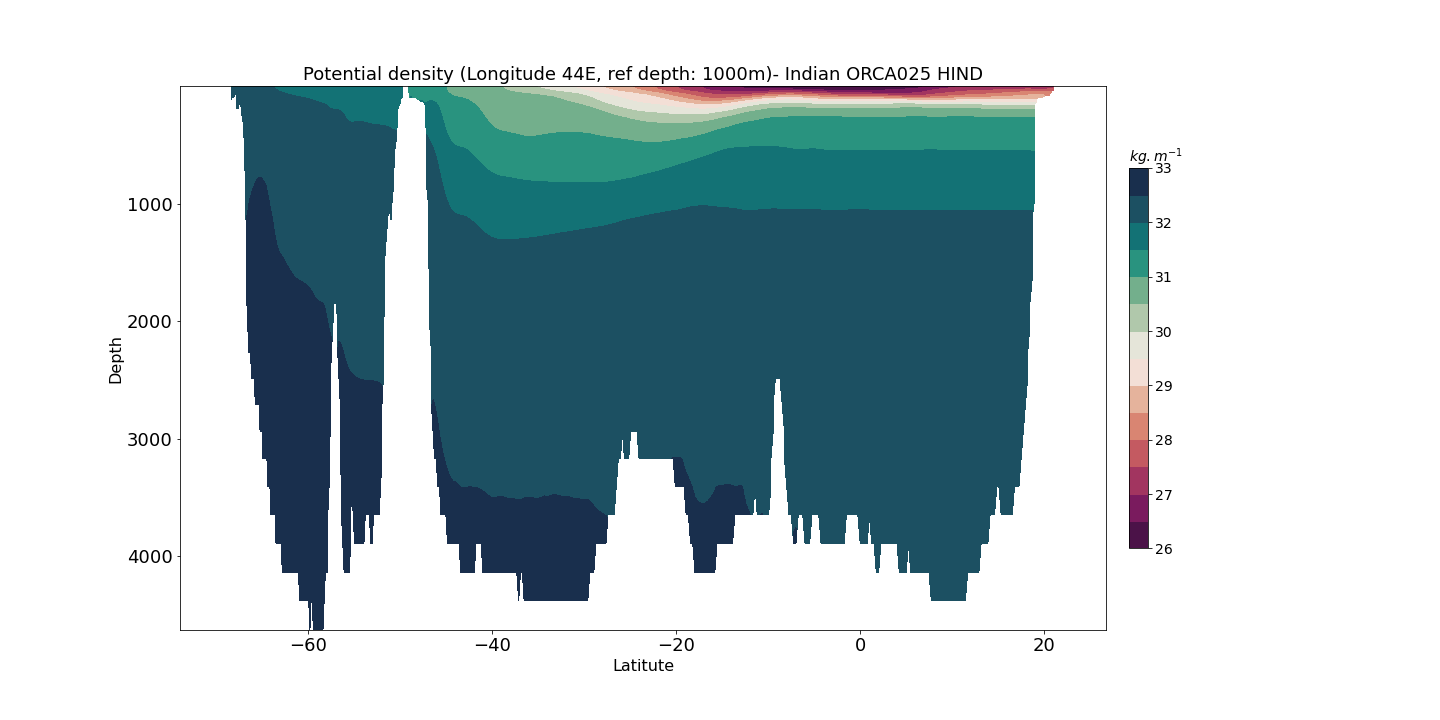

In [13]:
#Indian

plt.figure(figsize=(20,10))
ax = plt.gca()

map3 = plt.contourf(lat[50:610], depth[:41], rho_ind_h.isel(y=slice(50,610), deptht=slice(0,41)), levels=12,
                     cmap = cm.curl_r, norm= colors.Normalize())

axes.Axes.tick_params(ax, axis='both' ,labelsize=18)
plt.title('Potential density (Longitude 44E, ref depth: 1000m)- Indian ORCA025 HIND', fontsize=18)
plt.xlabel('Latitute', fontsize=16)
plt.ylabel('Depth', fontsize=16)
c= plt.colorbar(map3, pad=0.02, shrink=0.7, ax=ax)
c.ax.set_title('$kg.m^{-1}$', loc='left', fontsize=14)
c.ax.tick_params(labelsize=14)
ax.invert_yaxis()

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/'
plt.savefig(savepath + 'density_ind_hind.png', format='png', facecolor="w")